In [1]:
import itertools
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests

from datetime import datetime
from dateutil.relativedelta import *
from matplotlib.dates import DateFormatter
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.basemap import Basemap
from notebook_utils import configure_path, setup_matplotlib
from pprint import pprint

In [2]:
configure_path()
setup_matplotlib()

## Ripe Atlas' footprint in Venezuela and RTT to Google's Public DNS

Although country-level data indicates that Venezuela’s median latency to Google Public DNS is higher compared to other LACNIC region countries, there is notable variability in latency among probes within Venezuela, including some with latencies comparable to peer countries.

Next, we explore whether the geographic location of these probes in Venezuela could contribute to the observed differences in median latency.

To examine if there is a correlation between the geographical coordinates of each probe in Venezuela and their minimum latency to Google Public DNS, we analyzed data from the latest snapshot.

In [3]:
INIT_DATE = datetime(2014, 1, 1)
MAX_LATENCY = 700

In [4]:
def geneate_filename(cc, d):
    dir = f"data/raw/12-20-google-dns/{cc}"

    return f"{dir}/{cc}_{d.strftime('%Y_%m_%d')}.csv.gz"


def get_prb_rtt(filename):
    """
    If routes experienced load balanced or route changes, a probe could have
    obtained more than one hops count to get to google
    """
    try:
        df = pd.read_csv(filename, compression="gzip")

        # This removes failed traceroutes that have TTL=255
        return (
            df.loc[(df["hop"] < 60) & (df["rtt"] > 0)]
            .groupby("prb_id")["rtt"]
            .min()
            .reset_index()
        )
    except:
        return pd.DataFrame()

In [5]:
rtts = pd.DataFrame()

for cc in [
    "VE",
]:

    d = INIT_DATE

    while d < datetime.now():

        filename = geneate_filename(cc, d)

        if os.path.exists(filename):
            _rtts = get_prb_rtt(filename)

            if _rtts.size > 0:
                _rtts["date"] = np.repeat(d, _rtts.shape[0])
                rtts = pd.concat([_rtts, rtts])

        d += relativedelta(months=+1)

In [6]:
rtts.head()

,prb_id,rtt,date
0,7049,39.758,2023-08-01
1,11180,33.158,2023-08-01
2,12849,47.399,2023-08-01
3,30045,39.128,2023-08-01
4,30048,25.708,2023-08-01


In [7]:
def _get_probe_info(prb_id):
    URL = "https://atlas.ripe.net/api/v2/probes/{}/"
    return requests.get(URL.format(prb_id)).json()


def get_probe_asn(prb_id):
    prb_info = _get_probe_info(prb_id)

    if "asn_v4" in prb_info.keys():
        if prb_info["asn_v4"] is not None:
            return int(prb_info["asn_v4"])

    return 0


def get_name_from_ripestat(asn):
    r = requests.get(f"https://stat.ripe.net/data/as-names/data.json?resource={asn}")

    if r.status_code == 200:

        j = r.json()

        if "data" in j.keys():
            if "names" in j["data"].keys():
                if str(asn) in j["data"]["names"].keys():
                    if len(j["data"]["names"][str(asn)]) > 0:
                        asname = j["data"]["names"][str(asn)]
                    else:
                        asname = ""
                else:
                    asname = ""
            else:
                asname = ""

        else:
            asname = ""
    else:
        asname = ""

    return asname

In [8]:
asns = []
for prb in rtts.drop_duplicates("prb_id")["prb_id"].values:
    asn = get_probe_asn(prb)
    asname = get_name_from_ripestat(asn)
    asns.append([prb, asn, asname])

asns = pd.DataFrame(asns, columns=["prb_id", "asn", "asname"])

In [9]:
rtts = rtts.join(
    asns.set_index(
        [
            "prb_id",
        ]
    ),
    on=[
        "prb_id",
    ],
    how="left",
    lsuffix="_left",
    rsuffix="_right",
)

In [10]:
closeby_details = {}
for idx, row in rtts.loc[rtts["rtt"] < 20].drop_duplicates("prb_id").iterrows():
    closeby_details[row["prb_id"]] = _get_probe_info(row["prb_id"])

In [11]:
pprint(closeby_details[list(closeby_details.keys())[0]])

{'address_v4': '190.97.252.2',
 'address_v6': None,
 'asn_v4': 263703,
 'asn_v6': None,
 'country_code': 'VE',
 'description': 'TL-MR3020',
 'firmware_version': 4770,
 'first_connected': 1589823818,
 'geometry': {'coordinates': [-71.4115, 8.5385], 'type': 'Point'},
 'id': 33132,
 'is_anchor': False,
 'is_public': True,
 'last_connected': 1720800235,
 'prefix_v4': '190.97.252.0/24',
 'prefix_v6': None,
 'status': {'id': 1, 'name': 'Connected', 'since': '2024-07-12T14:53:04Z'},
 'status_since': 1720795984,
 'tags': [{'name': 'system: V3', 'slug': 'system-v3'},
          {'name': 'system: Resolves A Correctly',
           'slug': 'system-resolves-a-correctly'},
          {'name': 'system: Resolves AAAA Correctly',
           'slug': 'system-resolves-aaaa-correctly'},
          {'name': 'system: IPv4 Works', 'slug': 'system-ipv4-works'},
          {'name': 'system: IPv4 Capable', 'slug': 'system-ipv4-capable'},
          {'name': 'system: IPv4 RFC1918', 'slug': 'system-ipv4-rfc1918'},
    

In [12]:
def plot_city(ax, lat, lon, name, m):
    x, y = m(lat, lon)
    ax.plot(x, y, marker="*", color="black", markersize=20)
    ax.plot(x, y, marker="*", color="gold", markersize=18)

    ax.annotate(name, xy=(x, y), ha="center", va="bottom", fontsize=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


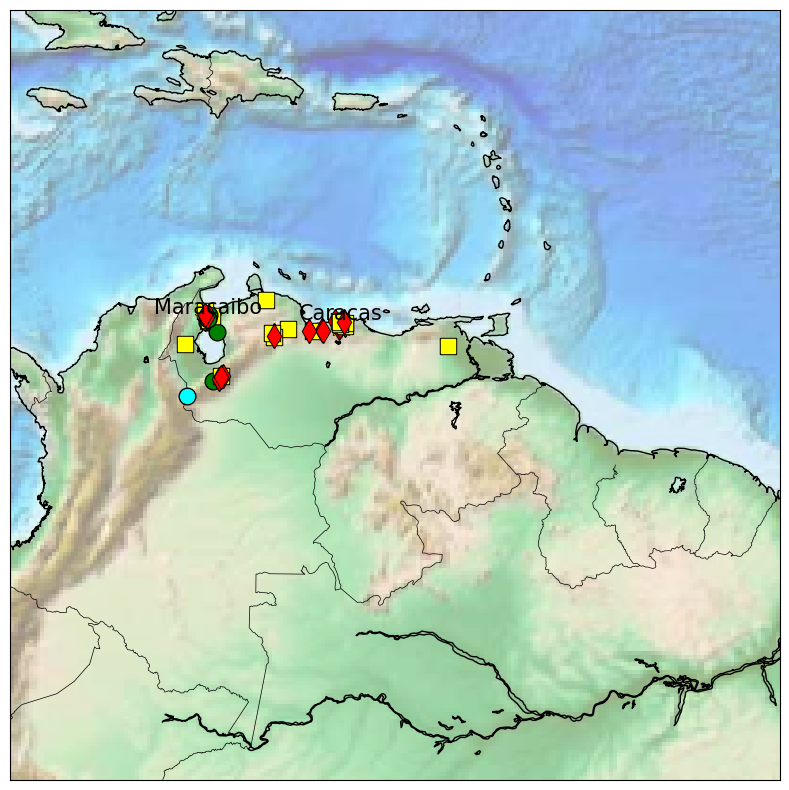

In [13]:
fig, ax = plt.subplots(1, figsize=(10, 8))


m = Basemap(
    projection="lcc", lat_0=8, lon_0=-65, width=3e6, height=3e6, resolution="i", ax=ax
)
m.etopo(scale=0.5, alpha=0.5)

m.drawcountries()
m.drawcoastlines()

name = "Maracaibo"
lon, lat = (10.653860, -71.645966)
plot_city(ax, lat, lon, name, m)

name = "Caracas"
lon, lat = (10.500000, -66.916664)
plot_city(ax, lat, lon, name, m)

for idx, row in rtts.drop_duplicates("prb_id").iterrows():
    details = _get_probe_info(row["prb_id"])

    lat, lon = details["geometry"]["coordinates"]
    lat += np.random.uniform(-0.1, 0.1)
    lon += np.random.uniform(-0.1, 0.1)
    x, y = m(lat, lon)

    mrtt = rtts.loc[(rtts["prb_id"] == row["prb_id"])]["rtt"].min()

    if mrtt < 10:
        marker = "o"
        color = "cyan"
    elif mrtt < 20:
        marker = "o"
        color = "green"
    elif mrtt < 40:
        marker = "s"
        color = "yellow"
    elif mrtt < 100:
        marker = "d"
        color = "red"
    else:
        marker = "^"
        color = "purple"

    ax.plot(x, y, marker=marker, color="black", markersize=12)
    ax.plot(x, y, marker=marker, color=color, markersize=10)

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig(f"figures/20-ve_gpdns_minrtt_map.pdf")

The figure features a map that marks each probe’s location, color-coded by their minimum latency to Google Public DNS: below 10ms (Cyan circles), 10-20ms (Green circles), 20-40ms (Yellow squares), and above 40ms (Red diamonds). The map reveals that the only probes achieving latencies under 10ms to Google Public DNS are located along the Colombian border, and slightly further, in the Maracaibo region, some probes exhibit latencies in the 10-20ms range. A noticeable trend of increasing latency with distance from the Colombian border suggests that no GPDNS server within Venezuela serves these probes.

In [14]:
rtts.loc[rtts["rtt"] < 10]

,prb_id,rtt,date,asn,asname
24,1005858,9.809,2023-08-01,271791,CABLE NORTE CA.
23,1005858,9.948,2023-07-01,271791,CABLE NORTE CA.


In [15]:
rtts.loc[rtts["rtt"] < 20].drop_duplicates("prb_id")

,prb_id,rtt,date,asn,asname
6,33132,12.030,2023-08-01,263703,VIGINET C.A
24,1005858,9.809,2023-08-01,271791,CABLE NORTE CA.
7,60343,19.075,2023-07-01,61461,Airtek Solutions C.A.
10,60707,19.524,2023-07-01,61461,Airtek Solutions C.A.
15,62164,19.456,2023-07-01,271909,TELECOMUNICACIONES
20,1004928,19.339,2023-07-01,61461,Airtek Solutions C.A.
4,30008,18.401,2023-03-01,269782,NETWORK SPEED C.A
6,30048,18.924,2023-03-01,61461,Airtek Solutions C.A.
16,61617,18.909,2023-03-01,270073,IGUANA NETWORK SERVICES C.A.
20,1005033,19.202,2023-03-01,61461,Airtek Solutions C.A.


## Probe count per as

In [16]:
rtts.groupby(["prb_id", "asn", "asname"])["rtt"].min().reset_index().sort_values("rtt")

,prb_id,asn,asname,rtt
49,1005858,271791,CABLE NORTE CA.,9.809
25,33132,263703,VIGINET C.A,11.885
19,30008,269782,NETWORK SPEED C.A,18.401
46,1004928,61461,Airtek Solutions C.A.,18.588
34,60707,61461,Airtek Solutions C.A.,18.887
37,61617,270073,IGUANA NETWORK SERVICES C.A.,18.909
22,30048,61461,Airtek Solutions C.A.,18.924
31,60343,61461,Airtek Solutions C.A.,19.075
47,1005033,61461,Airtek Solutions C.A.,19.202
40,62164,271909,TELECOMUNICACIONES,19.456


In [17]:
c = (
    rtts.drop_duplicates("prb_id")
    .groupby(["asn", "asname"])["rtt"]
    .count()
    .reset_index()
    .sort_values("rtt", ascending=False)
).rename(columns={"rtt": "probe_count"})

In [18]:
c

,asn,asname,probe_count
12,61461,Airtek Solutions C.A.,8
2,8048,CANTV Servicios,7
7,21826,Corporacion Telemic C.A.,7
26,273155,DATANET VZLA 2021,2
24,271791,CABLE NORTE CA.,2
6,20312,Fundacion Centro Nacional de Innovacion Tecnol...,2
9,23007,Universidad de Los Andes,2
21,269820,FULL DATA COMUNICACIONES C.A.,2
16,265641,TELECOMUNICACIONES ROCARLI C.A CIX BROADBAND,1
25,271909,TELECOMUNICACIONES,1


In [19]:
c["probe_count"].sum()

51